In [57]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from db import helper as db_helper
from common import treat_data, extract_period_returns, reshape_df, extract_price_volatility
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [94]:
session = db_helper.start_session()
df = pd.read_sql_table('spot_rates', session.bind)

2019-05-05 21:13:34,025 INFO sqlalchemy.engine.base.Engine select version()
2019-05-05 21:13:34,029 INFO sqlalchemy.engine.base.Engine {}
2019-05-05 21:13:34,042 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-05-05 21:13:34,044 INFO sqlalchemy.engine.base.Engine {}
2019-05-05 21:13:34,054 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-05 21:13:34,055 INFO sqlalchemy.engine.base.Engine {}
2019-05-05 21:13:34,061 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-05 21:13:34,062 INFO sqlalchemy.engine.base.Engine {}
2019-05-05 21:13:34,064 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-05-05 21:13:34,065 INFO sqlalchemy.engine.base.Engine {}
2019-05-05 21:13:34,069 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind = 'r'
2019-05-05 21:

2019-05-05 21:13:34,205 INFO sqlalchemy.engine.base.Engine {}


In [95]:
df = treat_data(df)
# Split DF by currency
gbp_df = df[(df['base_currency']=='GBP')]
usd_df = df[(df['base_currency']=='USD')]
eur_df = df[(df['base_currency']=='EUR')]

df = extract_period_returns(gbp_df)
df = extract_price_volatility(df)
df = reshape_df(df)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/JaiPancholi/Sites/currency_analysis/notebooks/common.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currency_df['weekly_spot_rate_volatility'] = currency_df.rolling('7D')['target_spot_rate'].std()
/Users/JaiPancholi/Sites/currency_analysis/notebooks/common.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [102]:
df = df.dropna()
target_variable = 'USD_one_year_future_return'
X = df.drop(columns=[target_variable, 'date'])
y = df[target_variable]
cols_to_drop = [col for col in X.columns if col.endswith('future_return')]
X = X.drop(columns=cols_to_drop)

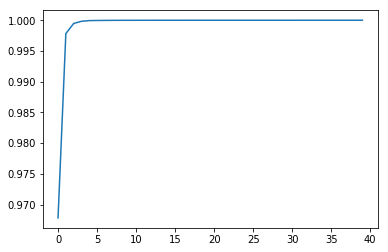

In [127]:
from sklearn.decomposition import PCA
pca = PCA()
X_r = pca.fit(X).transform(X)
sns.lineplot(x=range(X.shape[1]), y=pca.explained_variance_ratio_.cumsum())

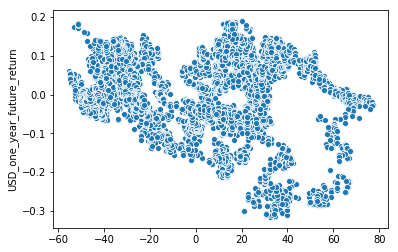

In [131]:
sns.scatterplot(x=X_r[:, 0], y=y)

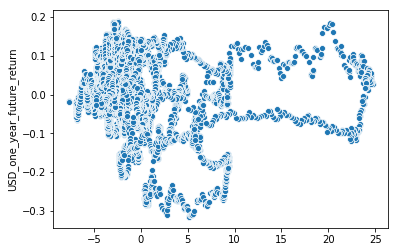

In [130]:
sns.scatterplot(x=X_r[:, 1], y=y)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Text(0.5,1,'R-Squared on Models Predicting Annual Return on GBP:USD Rate')

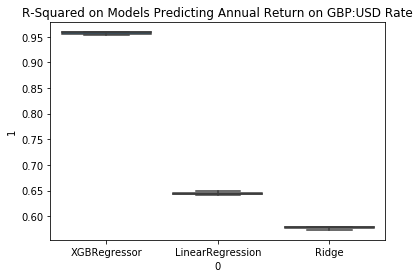

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = [
    XGBRegressor(),
    LinearRegression(),
    Ridge(),
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

k_folds = 3
model_scores = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='r2', cv=k_folds)
    for accuracy in accuracies:
        model_scores.append([model_name, accuracy])

df = pd.DataFrame(model_scores)
ax = sns.boxplot(x=0, y=1, data=df)
ax.set_title('R-Squared on Models Predicting Annual Return on GBP:USD Rate')

In [105]:
from sklearn.metrics import r2_score
model = XGBRegressor()
model.fit(X_train, y_train)
y_test_hat = model.predict(X_test)
print(r2_score(y_test, y_test_hat))

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.9626797781079296


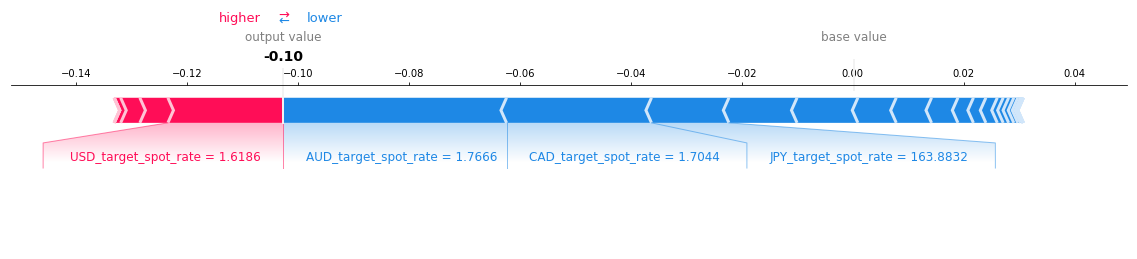

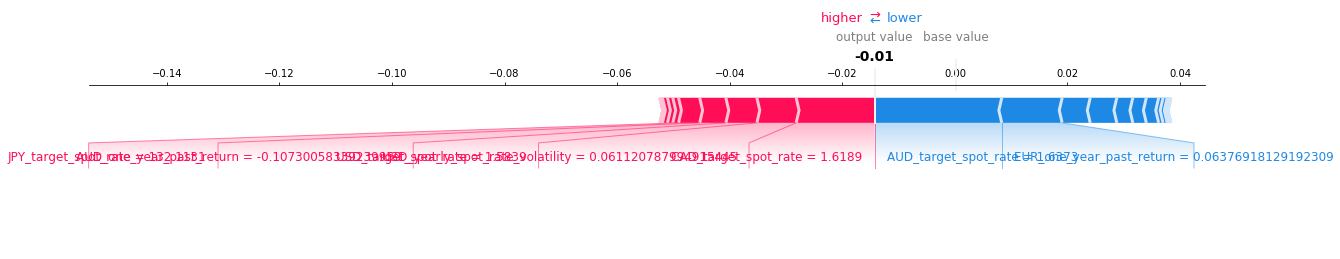

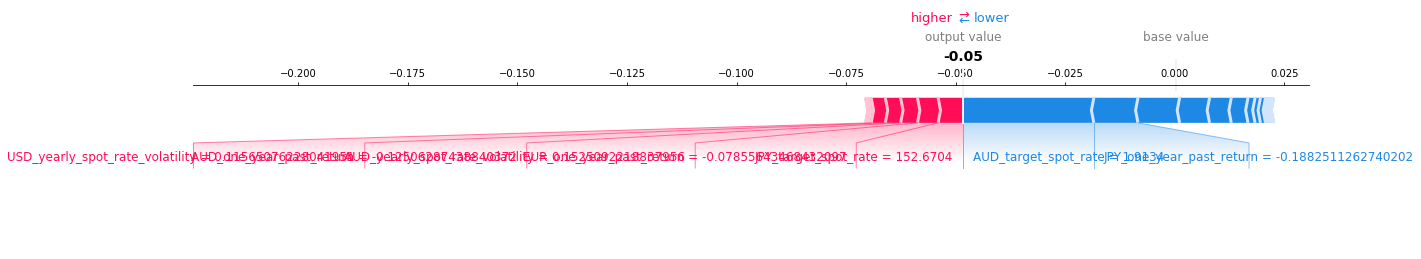

In [106]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[1,:], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[500,:], X_test.iloc[500,:], matplotlib=True)

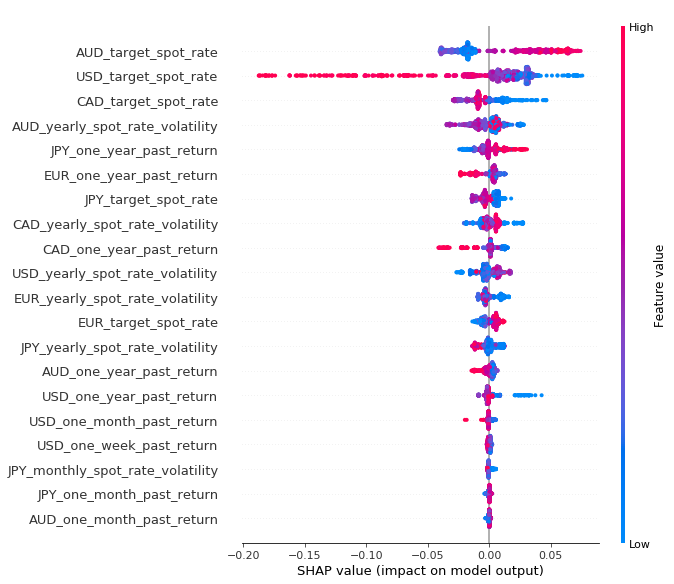

In [107]:
shap.summary_plot(shap_values, X_test)